<a href="https://colab.research.google.com/github/Abdul-139/RAMAN/blob/main/Workshop_Chemometric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Package

In [ ]:
!pip install rampy

In [ ]:
# widget for preprocessing selection
import ipywidgets as widgets
from ipywidgets import IntRangeSlider, IntSlider, ToggleButtons, ToggleButton, Dropdown
from IPython.display import display

class PreprocessingDropdown:
    def __init__(self, min_spec, max_spec, len_spec):
        self.all_preprocessing = [
            ('None', None),
            ('Baseline Removal', 'baseline'),
            ('Spikes Removal', 'spikes'),
            ('Smoothing Signal', 'smoothing'),
            ('Normalization', 'normalize'),
            ('Derivative', 'derivative'),
            ('Outlier Removal', 'outlier'),
            ('Selecting Spectrum', 'selecting')
        ]

        self.preprocessing_dropdowns = []
        self._all_baseline_methods = ['arPLS', 'poly', 'drPLS', 'als']
        self.min_spec, self.max_spec, self.len_spec = min_spec, max_spec, len_spec

    def _create_widget(self, widget_function, **kwargs):
        return widget_function(**kwargs)

    def _create_preprocessing_dropdown(self):
        for i in range(len(self.all_preprocessing) - 1):
            dropdown_created = self._create_widget(
                Dropdown,
                options=self.all_preprocessing,
                value=None,
                description=f'Pre-processing {i+1}',
                layout={'visibility': 'hidden'} if i > 0 else {'visibility': 'visible'}
            )
            self.preprocessing_dropdowns.append(dropdown_created)

        self.widget_box = widgets.VBox([self.preprocessing_dropdowns[0]])

    def _create_preprocessing_detial(self):
        min_spec, max_spec = 0, 10
        # outlier removal
        self.outlier_methods = self._create_widget(ToggleButtons, options=['similarity', 'signal to noise'], continuous_update=True, readout=True,
                                                        description='Methods :', disabled=False, button_style='', layout={'visibility': 'hidden'})
        # smoothing signal
        self.smoothing_window = self._create_widget(IntSlider, value=0, min=0, max=self.len_spec, step=1, continuous_update=True, readout=True,
                                                        description='Window :', desabled=False, button_style='', layout={'visibility': 'hidden'})
        self.smoothing_order = self._create_widget(IntSlider, value=1, min=0, max=10, step=1, continuous_update=True, readout=True,
                                                    description='Order :', desabled=False, button_style='', layout={'visibility': 'hidden'})

        # devrivative
        self.derivative_order = self._create_widget(IntSlider, value=1, min=0, max=5, step=1, continuous_update=True, readout=True,
                                                        description='Window :', desabled=False, button_style='', layout={'visibility': 'hidden'})

        # selected spectrum
        self.selected_spectrum = self._create_widget(IntRangeSlider, value=[self.min_spec, self.max_spec], min=self.min_spec, max=self.max_spec, step=1, continuous_update=True, readout=True,
                                                     description='Selected Spectrum', disabled=False, button_style='', layout={'visibility': 'hidden'})

        # baseline removal
        self.baseline_methods = self._create_widget(ToggleButtons, options=self._all_baseline_methods, continuous_update=True, readout=True,
                                                    description='Methods :', disabled=False, button_style='', layout={'visibility': 'hidden'})
        self.baseline_order = self._create_widget(IntSlider, value=1, min=1, max=10, step=1, continuous_update=True, readout=True,
                                                    description='Order :', disabled=False, button_style='', layout={'visibility': 'hidden'})

        # spikes removal
        self.spikes_methods = self._create_widget(ToggleButtons, options=['Median Filter'], continuous_update=True, readout=True,
                                                    description='Methods :', disabled=False, button_style='', layout={'visibility': 'hidden'})
        self.spikes_thd = self._create_widget(IntSlider, value=1, min=1, max=51, step=2, continuous_update=True, readout=True,
                                                    description='Threshold :', desabled=False, button_style='', layout={'visibility': 'hidden'})

        # normalization
        self.normalization = self._create_widget(ToggleButtons, options=['solve 1'], continuous_update=True, readout=True,
                                                    description='Methods :', disabled=False, button_style='', layout={'visibility': 'hidden'})

    def _filter_preprocessing(self, values):
        return [item for item in self.all_preprocessing if item[1] not in values]

    def _define_mapping(self):
        self.preprocessing_mapping = {
            'outlier': [self.outlier_methods],
            'baseline': [self.baseline_methods],
            'spikes': [self.spikes_thd, self.spikes_methods],
            # 'spikes': [self.spikes_methods],
            'smoothing': [self.smoothing_order, self.smoothing_window],
            'derivative': [self.derivative_order],
            'selecting': [self.selected_spectrum],
            'normalize': [self.normalization]
        }

    def _update_dropdown(self, change, index):
        if self.preprocessing_dropdowns[index].value is not None:
            selected_values = [dropdown.value for dropdown in self.preprocessing_dropdowns[:index + 1] if dropdown.value]
            next_dropdown = self.preprocessing_dropdowns[index + 1] if index + 1 < len(self.preprocessing_dropdowns) else None

            if next_dropdown:
                next_dropdown.options = self._filter_preprocessing(selected_values)
                next_dropdown.layout.visibility = 'visible'
                if next_dropdown not in self.widget_box.children:
                    self.widget_box.children += (next_dropdown,)

            self._define_mapping()

            # separate: 1 ---
            for key, widgets in self.preprocessing_mapping.items():
                if key in selected_values:
                    for widget in widgets:
                        widget.layout.visibility = 'visible'
                        if widget not in self.widget_box.children:
                            insert_index = self.widget_box.children.index(self.preprocessing_dropdowns[index]) + 1
                            self.widget_box.children = self.widget_box.children[:insert_index] + (widget,) + self.widget_box.children[insert_index:]
                else:
                    for widget in widgets:
                        if widget in self.widget_box.children:
                            self.widget_box.children = tuple(c for c in self.widget_box.children if c != widget)
            widget.layout.visibility = 'visible'
            # ------

        else:
            for dropdown in self.preprocessing_dropdowns[index+1:]:
                dropdown.layout.visibility = 'visible'
                self.widget_box.children = self.widget_box.children[:index+1]
        # separate: 2
        for key, widgets in self.preprocessing_mapping.items():
            if all(dropdown.value != key for dropdown in self.preprocessing_dropdowns):
                for widget in widgets:
                    widget.layout.visibility = 'visible'
        # ------

    def _baseline_method_change(self, change):
        if change['new'] == self._all_baseline_methods[1]:
            self.baseline_order.layout.visibility = 'visible'
            if self.baseline_order not in self.widget_box.children:
                insert_index = self.widget_box.children.index(self.baseline_methods) + 1
                self.widget_box.children = self.widget_box.children[:insert_index] + (self.baseline_order,) + self.widget_box.children[insert_index:]

        else:
            self.baseline_order.layout.visibility = 'hidden'
            if self.baseline_order in self.widget_box.children:
                self.widget_box.children = tuple(c for c in self.widget_box.children if c != self.baseline_order)

    def process(self):
        self._create_preprocessing_dropdown()
        self._create_preprocessing_detial()

        for i in range(len(self.preprocessing_dropdowns)):
            self.preprocessing_dropdowns[i].observe(lambda change, i=i: self._update_dropdown(change, i), names='value')
        self.baseline_methods.observe(self._baseline_method_change, names='value')


        display(self.widget_box)
        self._define_all_params()
        # for method, params in self.all_params.items():
        #     # print(params)
        #     for param, widget in params.items():
        #         print(widget)
        #         widget.observe(self._toggle_change, names='value')

    def _toggle_change(self, change):
        self._define_all_params()

    def _define_all_params(self):
        self.all_params = {
            'baseline': {'method': self.baseline_methods, 'order': self.baseline_order},
            'spikes': {'methods': self.spikes_methods, 'threshold': self.spikes_thd},
            'smoothing': {'window': self.smoothing_window, 'order': self.smoothing_order},
            'derivative': {'order': self.derivative_order},
            'outlier': {'methods': self.outlier_methods},
            'normalize': {'method': self.normalization},
            'selecting': {'spectrum_range': self.selected_spectrum}
        }

    def get_params(self):
        for method, params in self.all_params.items():
            for param, widget in params.items():
                widget.observe(self._toggle_change, names='values')

        return self.preprocessing_dropdowns, self.all_params

In [ ]:
# from zipfile import ZipFile
import zipfile
from pathlib import Path
import pandas as pd
import numpy as np
import re


class FileReading:
    def __init__(self, path, measurement):
        if Path(path).suffix == '.zip':
            self._extract_zip(path)
            self.file_path = Path(path.split('.')[0])
        else:
            self.file_path = Path(path)
        self.measurment = measurement
        self.columns = ['dataset', 'country', 'province', 'filename', 'x_data', 'y_data']
        self.all_data = {key: [] for key in self.columns}

    def _find_delimiter(self, f_path):
        with open(f_path, 'r') as file:
            for num, line in enumerate(file):
                if num == 1:
                    pattern = r'[^0-9.-]'
                    delimiter = ''.join(re.findall(pattern, line))
        return delimiter.replace('\n', '')

    def _extract_zip(self, file_path):
        with zipfile.ZipFile(file_path, 'r') as zip_file:
            zip_file.extractall()

    def _append(self, list_value):
        for index, key in enumerate(self.columns):
            self.all_data[key].append(list_value[index])

    def _read_uv(self, dataset, country, province, file):
        data = pd.read_excel(file)
        x_data = np.array(data[data.columns[0]])
        for col in data.columns[1:]:
            if not data[col].isnull().any():
                y_data = np.array(data[col])
                self._append([dataset, country, province, file.name, x_data, y_data])

    def _read_ftir(self, dataset, country, province, file):
        data = np.genfromtxt(f'{file}', delimiter=self._find_delimiter(file))
        self._append([dataset, country, province, file.name, data[:, 0], data[:, 1]])

    def _read_raman(self, dataset, country, province, file):
        data = np.genfromtxt(f'{file}')
        num_spec = sum(1 for i in range(len(data)) if data[i-1, 0] != data[i, 0] or data[i-1, 1] != data[i, 1])
        point_spec = int(len(data)/ num_spec)

        for begin_raman in range(0, len(data), point_spec):
            end_raman = begin_raman + point_spec
            raman = data[begin_raman: end_raman, 2]
            inten = data[begin_raman: end_raman, 3]
            self._append([dataset, country, province, file.name, raman, inten])

    def read_file(self):
        for dataset_path in self.file_path.iterdir():
            if dataset_path.stem == '.DS_Store':
                continue
            for country_path in dataset_path.iterdir():
                if country_path.stem == '.DS_Store':
                    continue
                for province_path in country_path.iterdir():
                    if province_path.stem == '.DS_Store':
                        continue
                    for i, file in enumerate(province_path.iterdir()):
                        if file.stem == '.DS_Store':
                            continue
                        if self.measurment == 'UV-Vis':
                            self._read_uv(str(dataset_path.stem), str(country_path.stem), str(province_path.stem), file)
                        elif self.measurment == 'FTIR':
                            self._read_ftir(str(dataset_path.stem), str(country_path.stem), str(province_path.stem), file)
                        elif self.measurment == 'Raman Spectroscopy':
                            self._read_raman(str(dataset_path.stem), str(country_path.stem), str(province_path.stem), file)

        return self.all_data




In [ ]:
import rampy as rp
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from scipy.interpolate import interp1d


def preprocessing_process(raw_data, steps, params):
    df = pd.DataFrame(raw_data)
    for index, step in enumerate(steps):
        if step is None:
            continue
        # selecting spectrum
        if step == 'selecting':
            selecting_params = {key: params[step][key].value for key in params[step].keys()}
            for index, row in df.iterrows():
                x_data, y_data = row['x_data'], row['y_data']
                min_spec, max_spec = selecting_params['spectrum_range'][0], selecting_params['spectrum_range'][1]
                mask = (x_data >= min_spec) * (x_data <= max_spec)
                row['x_data'], row['y_data'] = x_data[mask], y_data[mask]

            min_com = min([len(row['x_data']) for index, row in df.iterrows()])
            for i, row in df.iterrows():
                row['x_data'] = row['x_data'][0: min_com]
                row['y_data'] = row['y_data'][0: min_com]
                # print(len(row['x_data']), len(row['y_data']))



        # normalization
        if step == 'normalize':
            for index, row in df.iterrows():
                row['y_data'] = row['y_data']/ max(row['y_data'])

        # smoothing signal
        if step == 'smoothing':
            smoothing_params = {key: params[step][key].value for key in params[step].keys()}
            for index, row in df.iterrows():
                row['y_data'] = savgol_filter(row['y_data'], smoothing_params['window'], smoothing_params['order'])

        # derivative
        if step == 'derivative':
            derivative = {key: params[step][key].value for key in params[step].keys()}
            for index, row in df.iterrows():
                row['y_data'] = np.gradient(row['y_data'], derivative['order'])

        # baseline
        if step == 'baseline':
            # print(step)
            baseline_params = {key: params[step][key].value for key in params[step].keys()}
            for index, row in df.iterrows():
                new_inten, baseline = rp.baseline(
                    row['x_data'],
                    row['y_data'],
                    np.array([(row['x_data'][np.argmin(row['x_data'])], row['x_data'][np.argmax(row['x_data'])])]),
                    method=baseline_params['method'],
                    polynomial_order=baseline_params['order']
                )
                row['y_data'] = np.reshape(new_inten, len(new_inten))

        # spikes
        if step == 'spikes':
            spikes_params = {key: params[step][key].value for key in params[step].keys()}
            for index, row in df.iterrows():
                row['y_data'] = medfilt(row['y_data'], spikes_params['threshold'])


    plt.figure(figsize=(5, 15))
    for i, label in enumerate(list(set(df['country']))):
        new_df = df[df['country'] == label].reset_index(drop=True)
        plt.plot(new_df['x_data'].mean(), new_df['y_data'].mean()/max(new_df['y_data'].mean())+i, label = label)
    plt.legend()
    plt.xlabel('Wavenumber')
    plt.ylabel('Intensity')
    plt.yticks([])
    return df



In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

def MachineLearing(df, model):
    # Principal Components Analysis
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform([list(value) for value in df['y_data']])
    df['com1'] = pca_data[:, 0]
    df['com2'] = pca_data[:, 1]

    # plot pca
    plt.figure(figsize=(10, 5))
    for label in list(set(df['country'])):
        x_pc = df.loc[df['country'] == label, 'com1']
        y_pc = df.loc[df['country'] == label, 'com2']
        plt.scatter(x_pc, y_pc, label=label)
    plt.title('Principal Components Analysis: PCA', fontsize='20')
    plt.xlabel('Component 1', fontsize='13')
    plt.ylabel('Component 2', fontsize='13')
    plt.legend(fontsize='13')
    plt.show()

    # Linear Discriminant Analysis
    print(str(model))
    if str(model)[0: -2] == 'LinearDiscriminantAnalysis':
        lda_data = model.fit_transform([list(value) for value in df['y_data']], list(df['country']))
        df['ld1'] = lda_data[:, 0]
        df['ld2'] = lda_data[:, 1]
        for label in list(set(df['country'])):
            x_ld = df.loc[df['country'] == label, 'ld1']
            y_ld = df.loc[df['country'] == label, 'ld2']
            plt.scatter(x_ld, y_ld, label=label)
        plt.title('LinearDiscriminantAnalysis', fontsize='20')
        plt.xlabel('LD1', fontsize='13')
        plt.ylabel('LD2', fontsize='13')
        plt.legend(fontsize='13')
        plt.show()

    # train test split
    train_set = df[df['dataset'] == 'train'][['y_data', 'country']]
    X_train, y_train = [list(value) for value in train_set['y_data']], list(train_set['country'])

    test_set = df[df['dataset'] == 'test'][['y_data', 'country']]
    X_test, y_test = [list(value) for value in test_set['y_data']], list(test_set['country'])

    # Machine learning Model
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Plotting Accuracy
    sns.heatmap(
        [
            [accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred, average='weighted'),
            recall_score(y_test, y_pred, average='weighted'),
            f1_score(y_test, y_pred, average='weighted')]
        ],
        annot=True,
        xticklabels=['Accuracy', 'Precision', 'Recall', 'F-1 score']

    )
    plt.show()

    # Print Accuracy
    print('Accuracy', accuracy_score(y_test, y_pred))
    print('Precision', precision_score(y_test, y_pred, average='weighted'))
    print('Recall', recall_score(y_test, y_pred, average='weighted'))
    print('F-1 score', f1_score(y_test, y_pred, average='weighted'))

    # Confusion Matrix
    confus = confusion_matrix(y_test, y_pred)
    sns.heatmap(confus, annot=True, xticklabels=list(set(df['country'])), yticklabels=list(set(df['country'])))
    # plt.xticklabels(list(set(df['country'])))



In [ ]:
import ipywidgets as widgets
from ipywidgets import ToggleButton, ToggleButtons, Button
from ipyfilechooser import FileChooser
from IPython.display import display
import matplotlib.pyplot as plt
# load machine learning model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier

class Chemometric:
    def _create_widgets(self, widget_function, **kwargs):
        return widget_function(**kwargs)

    def _on_confirm_click(self, change):
        # print(self.file_path, self.measurment) file_path, measurment
        preprocess_steps, preprocess_params = self.preprocessingdropdown.get_params()

        preprocess_steps = [step.value for step in preprocess_steps]
        df = preprocessing_process(self.raw_data, preprocess_steps, preprocess_params)
        MachineLearing(df, self.model_selected.value)
        # print(self.file_path, self.meansurment_selection.value)
        # print(preprocess_steps, preprocess_params, self.model_selected.value)


    def _on_meansurment_click(self, change):
        self.file_path = self.file_selection.value
        self.measurment = self.meansurment_selection.value

        # read file selected
        self.file_reading = FileReading(self.file_path, self.measurment)
        self.raw_data = self.file_reading.read_file()
        min_spec, max_spec = min(self.raw_data['x_data'][0]), max(self.raw_data['x_data'][0])
        len_spec = len(self.raw_data['x_data'][0])

        self.preprocessingdropdown = PreprocessingDropdown(min_spec, max_spec, len_spec) #get min max spectrum
        self.preprocessingdropdown.process()

        confirm = self._create_widgets(Button, description='Confirm')
        self.model_selected = self._create_widgets(
                Dropdown,
                options=[
                    ('LogisticRegression', LogisticRegression()),
                    ('KNeighborsClassifier', KNeighborsClassifier()),
                    ('DecisionTreeClassifier', DecisionTreeClassifier()),
                    ('RandomForestClassifier', RandomForestClassifier()),
                    ('GradientBoostingClassifier', GradientBoostingClassifier()),
                    ('AdaBoostClassifier', AdaBoostClassifier()),
                    ('ExtraTreesClassifier', ExtraTreesClassifier()),
                    ('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()),
                    ('QuadraticDiscriminantAnalysis', QuadraticDiscriminantAnalysis())
                ],
                value=None,
                description='Model: ',
                layout={'visibility': 'visible'}
            )
        display(self.model_selected)
        confirm.on_click(self._on_confirm_click)

        display(confirm)


    def processing(self):
        self.file_selection = FileChooser()

        # create measutment selection
        self.meansurment_selection = self._create_widgets(
            ToggleButtons,
            options=['None', 'Raman Spectroscopy', 'FTIR', 'UV-Vis'],
            description='Measurment :',
            disabled=False,
            button_style=''
        )

        self.meansurment_selection.observe(self._on_meansurment_click, names='value')
        display(self.file_selection, self.meansurment_selection)

### Use

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

FileChooser(path='/content', filename='', title='', show_hidden=False, select_desc='Select', change_desc='Chan…

ToggleButtons(description='Measurment :', options=('None', 'Raman Spectroscopy', 'FTIR', 'UV-Vis'), value='Non…

Dropdown(description='Model: ', layout=Layout(visibility='visible'), options=(('LogisticRegression', LogisticR…

Button(description='Confirm', style=ButtonStyle())

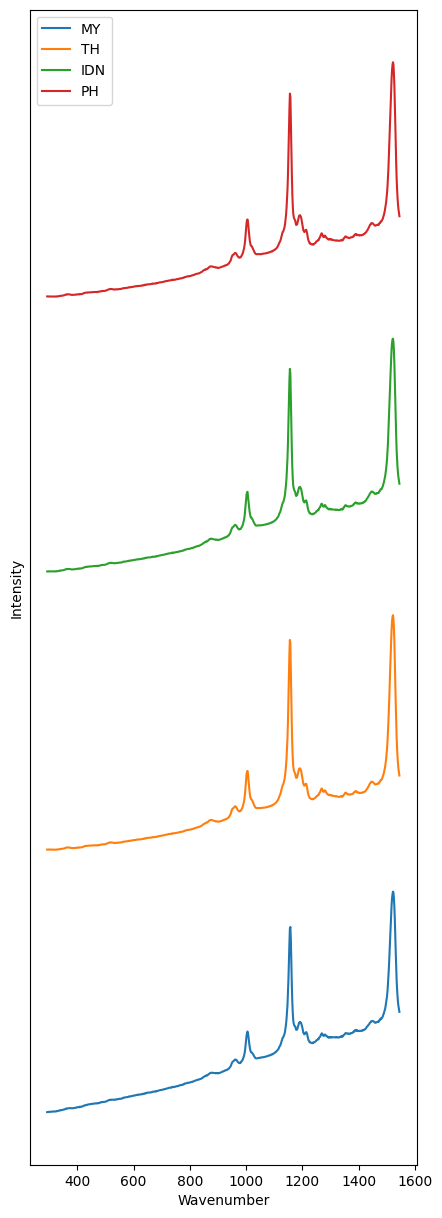

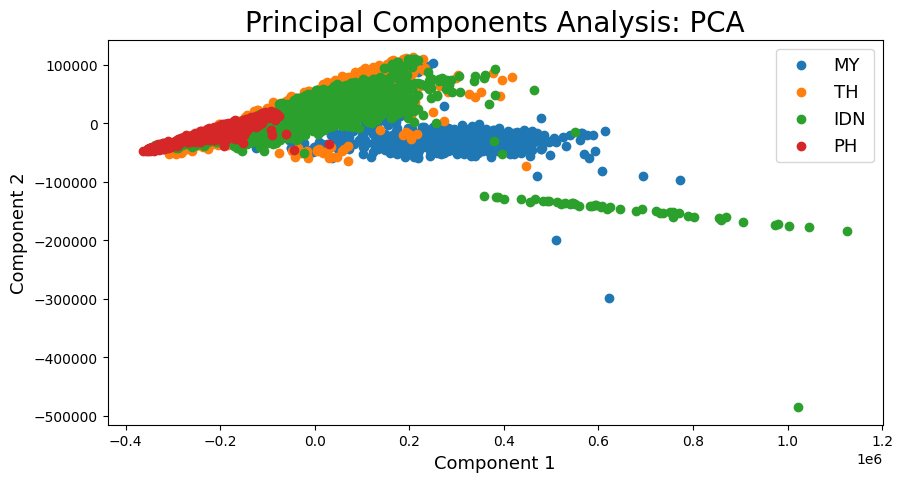

LinearDiscriminantAnalysis()


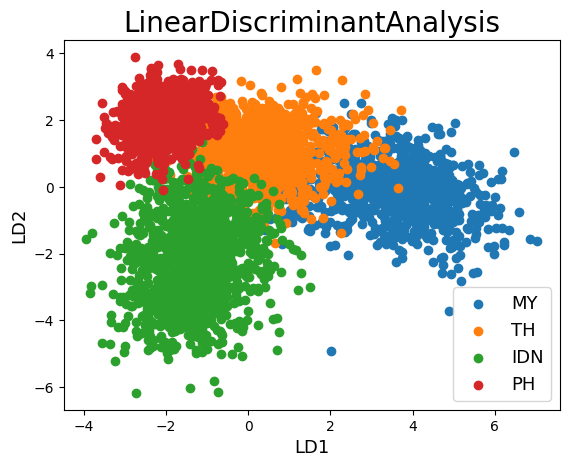

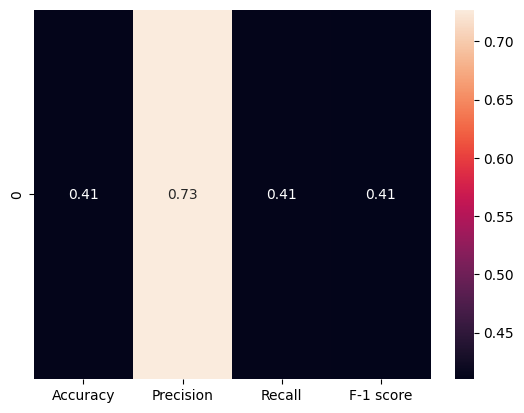

Accuracy 0.41118421052631576
Precision 0.7271166708801892
Recall 0.41118421052631576
F-1 score 0.4098913459759283


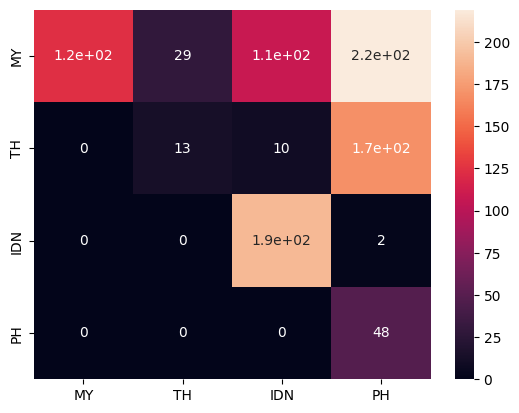

In [ ]:
chemometric = Chemometric()
chemometric.processing()